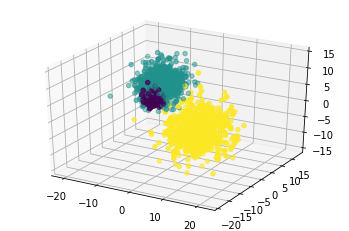

In [178]:
#生成高斯混合样本集
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from matplotlib.pyplot import savefig
from mpl_toolkits.mplot3d import Axes3D
font_set = FontProperties(fname='/Users/xinyujiang/code_tools/font/simsun.ttc', size=18)

#生成二维数据
#data,target=make_blobs(n_samples=10000,n_features=2,centers=[[-4,-7],[8,-3]], cluster_std=[1.0,3.0])

# 在2D图中绘制样本，每个样本颜色不同
#plt.scatter(data[:,0],data[:,1],c=target)
#plt.show()

#生成2类的三维数据
# data,target=make_blobs(n_samples=2000,n_features=3,centers=[[-4,-5,5],[-1,-3,4]], cluster_std=[1.0,3.0])
# ax = plt.axes(projection='3d')
# ax.scatter3D(data[:,0],data[:,1],data[:,2], c= target)

#生成3类的三维数据
data,target=make_blobs(n_samples=2000,n_features=3,centers=[[-4,-5,5],[-10,7,4],[10,-6,-2]], cluster_std=[1.0,3.0,4.0])
ax = plt.axes(projection='3d')
ax.scatter3D(data[:,0],data[:,1],data[:,2], c= target)

In [165]:
print(data[0], target[0])

[-6.62681867  4.10374214  7.53245123] 1


In [166]:
import numpy as np
#初始化参数
# #二维
# e = 0.05
# u1 = np.array([-5, -5])
# u2 = np.array([10, -5])
# std1 = 0.5
# std1 = std1*np.eye(2)
# std2 = 2
# std2 = std2*np.eye(2)
# p1 = 0.4#pi体现为该类样本所占总体样本的比例
# p2 = 0.6
##2类三维
# e = 0.05
# u1 = np.array([-5, -5,-5])
# u2 = np.array([10, -5,10])
# std1 = 0.5
# std1 = std1*np.eye(3)
# std2 = 2
# std2 = std2*np.eye(3)
# p1 = 0.4#pi体现为该类样本所占总体样本的比例
# p2 = 0.6
#3类三维
e = 0.01
u1 = np.array([-1, -5,3])
u2 = np.array([-3, -6,3])
u3 = np.array([-2, 3, -3])
u_list = [u1,u2,u3]
std1 = 2
std1 = std1*np.eye(3)
std2 = 0.5
std2 = std2*np.eye(3)
std3 = 3.5
std3 = std3*np.eye(3)
std_list = [std1,std2,std3]
p1 = 0.4#pi体现为该类样本所占总体样本的比例
p2 = 0.3
p3 = 0.3
p_list = [p1,p2,p3]

In [167]:
from scipy.stats import multivariate_normal
def Cal_Gaussian(data, u, std):
    #print(u.shape, std)
    norm = multivariate_normal(u, std)
    return norm.pdf(data)#得到一个(len(data),1)的矩阵

In [168]:
def E_step(data, u_list, std_list, p_list):
    q_list = []
    for i in range(len(u_list)):
        gaussian = Cal_Gaussian(data, u_list[i], std_list[i])
        q = p_list[i]*gaussian
        q_list.append(q)
    summ = sum(q_list)
    return [i/summ for i in q_list]

In [169]:
def M_step(data, u_list, q_list, dim):
    u_rt = []
    std_rt = []
    p_rt = []
    for i in range(len(u_list)):
        n = np.sum(q_list[i])
        u_new = np.dot(q_list[i],data)/n
        std_new = np.zeros((dim,dim))
        for j in range(len(data)):
        #print("std1",np.mat(q1[i]*(data-u1)[i,:]).T*np.mat(data-u1)[i,:])
            std_new += np.mat(q_list[i][j]*(data-u_list[i])[j,:]).T*np.mat(data-u_list[i])[j,:]
        #std1_new = np.dot(q1,(data-u1)*np.mat(data-u1).T)
        #std2_new = np.dot(q2,(data-u2)*np.mat(data-u2).T)
        std_new = std_new/n
        p_new = n/len(data)
        u_rt.append(u_new)
        std_rt.append(std_new)
        p_rt.append(p_new)
    return u_rt, std_rt, p_rt

In [170]:
def EM(data, u_list, std_list, p_list, epoch, dim, e):
    count = 0
    delta_u = 1
    delta_std = 1
    delta_p = 1
    while count < epoch and delta_u + delta_std + delta_p > e:
        count += 1
        print("Epoch========>",count)
        #print("std:",std1,std2)
        q_list = E_step(data, u_list, std_list, p_list)
        u_old, std_old, p_old = u_list, std_list, p_list
        u_list, std_list, p_list = M_step(data, u_list, q_list, dim)
        predict(data, u_list, std_list, [[-4,-5,5],[-10,7,4],[10,-6,-2]])
        delta_u = abs(sum([np.linalg.norm(i) for i in u_old])-sum([np.linalg.norm(i) for i in u_list]))
        delta_std = abs(sum([np.linalg.norm(i) for i in std_old])-sum([np.linalg.norm(i) for i in std_list]))
        delta_p = abs(sum([np.linalg.norm(i) for i in p_old])-sum([np.linalg.norm(i) for i in p_list]))
        print(delta_u,delta_std,delta_p)
    return u_list, std_list

In [172]:
import random
from sklearn.metrics import accuracy_score
from matplotlib.font_manager import FontProperties 
from sklearn.metrics.pairwise import pairwise_distances_argmin
accuracy_list = []
def predict(data, u_list, std_list, goldu_list):
    order = pairwise_distances_argmin(goldu_list, u_list, metric='euclidean')#确定预测高斯分布和实际高斯分布之间的对应关系
    u_list = np.array(u_list)[order].tolist()
    std_list = np.array(std_list)[order].tolist()
    y_list = []
    for i in range(len(u_list)):
        g = multivariate_normal(u_list[i], std_list[i])
        y = g.pdf(data)
        y_list.append(y)
    #计算估计类别
    acc = []
    for i in range(len(y_list[0])):
        max_p = 0
        max_idx = 0
        for j in range(len(y_list)):
            if y_list[j][i] > max_p:
                max_p = y_list[j][i]
                max_idx = j
        acc.append(max_idx)    
    print("准确率：%.4f" %accuracy_score(target,acc))
    accuracy_list.append(accuracy_score(target,acc))
    if len(data[0]) == 2:
        plt.scatter(data[y1>y2,0],data[y1>y2,1], c='r')
        plt.scatter(data[y1<y2,0],data[y1<y2,1], c='g')
        plt.suptitle(u'二维高斯混合模型的EM算法分类结果', fontproperties=font_set)
        plt.show()
    if len(data[0]) == 3:
        color = ['b','g','r','y','c','m','b','k','w']
        ax = plt.axes(projection='3d')
        ax.set_title(u'三维高斯混合模型的EM算法分类结果', fontproperties=font_set)
        for i in range(len(u_list)):
            ax.scatter3D(data[np.array(acc)==i,0],data[np.array(acc)==i,1],data[np.array(acc)==i,2],c = color[i])
        savefig('./pic/3Dresult'+str(random.randint(0,10000))+'.jpg')


Epoch========> 1
准确率：0.7050
0.16390217501045612 204.04004573037992 0.0
Epoch========> 2
准确率：0.7335
0.21631249897932037 7.004048715327485 0.0
Epoch========> 3
准确率：0.7680
0.545736537502183 10.455869122063774 0.0
Epoch========> 4
准确率：0.8035
1.4499569219286812 1.264852161801599 0.0
Epoch========> 5
准确率：0.8335
1.7110473468820544 17.042431407307248 0.0
Epoch========> 6
准确率：0.8650
1.6170940014790354 21.695098481295588 0.0
Epoch========> 7
准确率：0.8845
1.2467679834238758 14.185071864997923 0.0
Epoch========> 8
准确率：0.9040
0.9260478747269225 7.62698896673578 0.0
Epoch========> 9
准确率：0.9205
0.8895161467885586 8.625125829623244 0.0
Epoch========> 10
准确率：0.9415
0.9610453464026634 11.462980285657522 0.0
Epoch========> 11
准确率：0.9615
1.049012571151735 15.08292985823266 0.0
Epoch========> 12
准确率：0.9765
1.1622699617671621 19.544399882360935 0.0
Epoch========> 13
准确率：0.9885
1.2602557617105532 24.374409863269335 0.0
Epoch========> 14
准确率：0.9965
1.2002501036220927 26.12321850175296 0.0
Epoch========> 15
准确率：

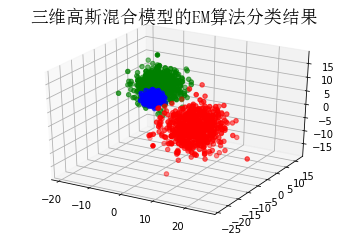

In [173]:
u_list, std_list = EM(data, u_list, std_list, p_list, 100, 3, e)

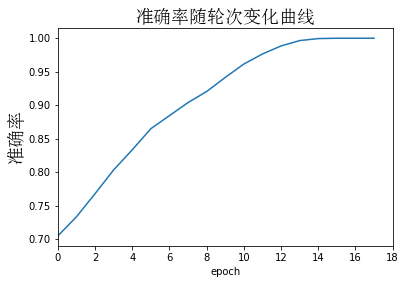

In [181]:
font_set = FontProperties(fname='/Users/xinyujiang/code_tools/font/simsun.ttc', size=18)
plt.plot([i for i in range(len(accuracy_list))], accuracy_list)
plt.title('准确率随轮次变化曲线',fontproperties=font_set)
plt.xlabel('epoch')
plt.ylabel('准确率',fontproperties=font_set)
plt.xlim(0,len(accuracy_list))#修改横坐标为整数
plt.show()

In [196]:
from sklearn.mixture import GaussianMixture
Gaussian = GaussianMixture(n_components=3, covariance_type='full', n_init=10, init_params='kmeans')
y = Gaussian.fit_predict(data)
accuracy_score(target,y)

0.9995